# Preprocessing blank cells

This notebook solely examines multiple techniques for recognition of blank cells.
Blank cells should be detected, marked as 0 in the board, and not passed to the digit recognition model.

In [32]:
import os
import cv2
import numpy as np
from pathlib import Path
import uuid

## Creating a cell image dataset

Subfolder `0` contains blank cells.
Other subfolders correspond to their filled values.

In [20]:
def save_cells_with_labels(cells, labels, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, row in enumerate(cells):
        for j, cell in enumerate(row):
            label = labels[i, j]
            label_dir = os.path.join(output_dir, str(label))
            if not os.path.exists(label_dir):
                os.makedirs(label_dir)

            # generate a unique filename using a UUID
            unique_id = uuid.uuid4().hex
            cell_path = os.path.join(label_dir, f"image_{unique_id}.png")
            cv2.imwrite(cell_path, cell)

In [21]:
def fragment_image(board_image):
    """Fragments the board image to the individual cells images"""
    cell_height, cell_width = board_image.shape[0] // 9, board_image.shape[1] // 9
    cells = []
    for i in range(9):
        row = []
        for j in range(9):
            x, y = j * cell_width, i * cell_height
            cell = board_image[y:y + cell_height, x:x + cell_width]
            row.append(cell)
        cells.append(row)
    return cells

In [22]:
def read_sudoku_from_dat(file_path: Path) -> np.ndarray:
    """Reads the sudoku board from a .dat file."""
    with open(file_path, "r") as file:
        lines = file.readlines()[2:]  # skip camera and img details
        board = []
        for line in lines:
            board.append([int(x) for x in line.split()])
        return np.array(board)

In [7]:
def fragment_and_save_cells(image_path, dat_path, output_dir):
    """
    Fragment a Sudoku board image into cells and save them with true labels.

    Args:
        image_path (str): Path to the Sudoku board image.
        dat_path (str): Path to the corresponding .dat file containing true labels.
        output_dir (str): Directory to save the cell images.
    """
    # load the Sudoku board image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # preprocess the image
    binary = cv2.adaptiveThreshold(
        image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 5
    )
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    pts1 = np.float32([[x, y], [x + w, y], [x, y + h], [x + w, y + h]])
    pts2 = np.float32([[0, 0], [450, 0], [0, 450], [450, 450]])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    warped = cv2.warpPerspective(binary, matrix, (450, 450))

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    warped = cv2.morphologyEx(warped, cv2.MORPH_OPEN, kernel)
    warped = cv2.bitwise_not(warped)

    # fragment the image into cells
    cells = fragment_image(warped)

    # read true labels from the .dat file
    labels = read_sudoku_from_dat(dat_path)

    # save cells with labels
    save_cells_with_labels(cells, labels, output_dir)

In [8]:
def create_cell_dataset(dataset_dir, output_dir):
    """
    Create a dataset of fragmented cells with true labels.

    Args:
        dataset_dir (str): Path to the dataset directory containing board images and .dat files.
        output_dir (str): Directory where the cell dataset will be saved.
    """
    for root, _, files in os.walk(dataset_dir):
        for file in files:
            if file.endswith(".jpg"):
                image_path = os.path.join(root, file)
                dat_path = image_path.replace(".jpg", ".dat")
                if os.path.exists(dat_path):
                    fragment_and_save_cells(image_path, dat_path, output_dir)
                else:
                    print(f"Warning: Missing .dat file for {image_path}")

In [11]:
dataset_dir = "../data/sudoku_dataset"
output_dir = "../data/cells"
create_cell_dataset(dataset_dir, output_dir)

In [33]:
from pathlib import Path

NUM_OF_IMAGES = 560
cells_num = sum(1 for _ in Path(output_dir).rglob('*') if _.is_file())
assert cells_num == NUM_OF_IMAGES*9*9

## Checking the dataset

In [13]:
import os

def count_files_in_subfolders(folder_path):
    """
    Count the number of files in each subfolder of a given folder.

    Args:
        folder_path (str): Path to the folder.

    Returns:
        dict: A dictionary with subfolder names as keys and file counts as values.
    """
    subfolder_counts = {}
    for root, dirs, files in os.walk(folder_path):
        if root != folder_path:  # Skip the root folder itself
            subfolder_name = os.path.basename(root)
            subfolder_counts[subfolder_name] = len(files)
    return subfolder_counts

# example usage
counts = count_files_in_subfolders(output_dir)
print("Image counts per subfolder:")
for subfolder, count in counts.items():
    print(f"{subfolder}: {count}")

Image counts per subfolder:
0: 18695
1: 2949
2: 2940
3: 2989
4: 2947
5: 2943
6: 2809
7: 2988
8: 3101
9: 2999


## Exploring methods for blank cell detection

### Evaluation Function Preparation

In [14]:
from tqdm import tqdm
from pathlib import Path
from typing import Callable, Dict
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import cv2
import numpy as np
from functools import partial


def evaluate_blank_recognition(data_dir: str, recognition_func: Callable, **kwargs) -> Dict[str, float]:
    """
    Evaluate a blank cell recognition function based on the data/cells structure.

    Args:
        data_dir (str): Path to the data/cells directory containing subfolders (0 for blank, 1-9 for digits).
        recognition_func (Callable): Function that takes a cell image and additional parameters (if any) and returns True if it's blank, False otherwise.
        **kwargs: Additional parameters for the recognition function.

    Returns:
        dict: Evaluation metrics (accuracy, precision, recall, F1-score).
    """
    true_labels = []
    predictions = []
    all_images = list(Path(data_dir).rglob("*.png"))  # Collect all image files

    
    for image_path in tqdm(all_images, desc="Evaluating blank cell recognition"):
        true_label = int(image_path.parent.name == "0")  # True if blank (folder "0"), else False
        cell_image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
        pred = recognition_func(cell_image, **kwargs)
        true_labels.append(true_label)
        predictions.append(pred)
    
    # calculate evaluation metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }


In [15]:
def recognize_blank(cell_image: np.ndarray) -> bool:
    """
    Example blank cell recognition function.
    Returns True if the cell is blank, otherwise False.
    """
    pass

### A) Mean Intensity

In [84]:
def recognize_blank_by_mean_intensity(cell_image: np.ndarray, threshold: int = 200) -> bool:
    """
    Example blank cell recognition function.
    Returns True if the cell is blank, otherwise False.
    """
    mean_intensity = np.mean(cell_image)
    return mean_intensity > threshold  # Example threshold

In [85]:
import pandas as pd
from tqdm import tqdm

results = []
for threshold in tqdm(range(150, 251, 5)):
    metrics = evaluate_blank_recognition("../data/cells", recognize_blank_by_mean_intensity, threshold=threshold)
    metrics["threshold"] = threshold
    results.append(metrics)


results_df = pd.DataFrame(results)
results_df.to_csv("blank_recognition_scores.csv", index=False)
print(results_df)

100%|██████████| 21/21 [06:26<00:00, 18.41s/it]

    accuracy  precision    recall  f1_score  threshold
0   0.586310   0.384106  0.006205  0.012212        150
1   0.586332   0.380623  0.005884  0.011589        155
2   0.586508   0.389892  0.005777  0.011385        160
3   0.586618   0.393939  0.005563  0.010971        165
4   0.586596   0.385542  0.005135  0.010135        170
5   0.586684   0.384279  0.004707  0.009300        175
6   0.586706   0.377358  0.004279  0.008462        180
7   0.586839   0.386139  0.004172  0.008255        185
8   0.586927   0.393939  0.004172  0.008257        190
9   0.586949   0.395939  0.004172  0.008257        195
10  0.586905   0.385027  0.003851  0.007626        200
11  0.586971   0.388889  0.003744  0.007417        205
12  0.586839   0.358025  0.003102  0.006152        210
13  0.586971   0.371795  0.003102  0.006154        215
14  0.587081   0.374101  0.002781  0.005522        220
15  0.587390   0.410256  0.002568  0.005103        225
16  0.587632   0.448980  0.002354  0.004683        230
17  0.5876

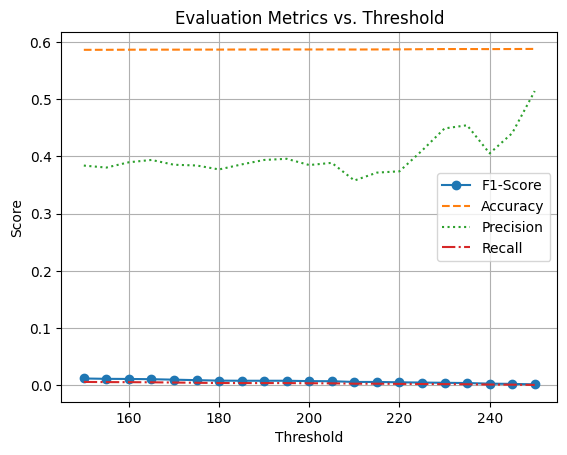

In [86]:
import matplotlib.pyplot as plt
import pandas as pd

plt.plot(results_df["threshold"], results_df["f1_score"], label="F1-Score", marker="o")
plt.plot(results_df["threshold"], results_df["accuracy"], label="Accuracy", linestyle="--")
plt.plot(results_df["threshold"], results_df["precision"], label="Precision", linestyle=":")
plt.plot(results_df["threshold"], results_df["recall"], label="Recall", linestyle="-.")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Evaluation Metrics vs. Threshold")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### B) Non-zero Pixel Count

In [87]:
def recognize_blank_by_nonzero_count(cell_image: np.ndarray, pixel_count_threshold: int = 50) -> bool:
    """
    Recognize blank cells based on the number of non-zero pixels.

    Args:
        cell_image (np.ndarray): Grayscale image of the cell.
        pixel_count_threshold (int): Maximum number of non-zero pixels for a blank cell.

    Returns:
        bool: True if the cell is blank, False otherwise.
    """
    _, binary_image = cv2.threshold(cell_image, 128, 255, cv2.THRESH_BINARY)
    non_zero_pixels = cv2.countNonZero(binary_image)
    return non_zero_pixels < pixel_count_threshold

In [88]:
import pandas as pd
from tqdm import tqdm

results = []
for pixel_count_threshold in tqdm(range(50, 200, 10)):
    metrics = evaluate_blank_recognition("../data/cells", recognize_blank_by_nonzero_count, 
                                         pixel_count_threshold=pixel_count_threshold)
    metrics["threshold"] = pixel_count_threshold
    results.append(metrics)


results_df = pd.DataFrame(results)
print(results_df)

100%|██████████| 15/15 [01:49<00:00,  7.30s/it]

    accuracy  precision    recall  f1_score  threshold
0   0.591887   0.537150  0.070768  0.125059         50
1   0.592681   0.541150  0.077026  0.134857         60
2   0.593849   0.547091  0.084515  0.146412         70
3   0.594863   0.550702  0.092378  0.158215         80
4   0.596517   0.558016  0.101097  0.171180         90
5   0.598214   0.563893  0.110939  0.185402        100
6   0.599118   0.564700  0.119283  0.196962        110
7   0.599780   0.563513  0.128377  0.209114        120
8   0.601080   0.565531  0.138486  0.222490        130
9   0.603373   0.571487  0.150522  0.238283        140
10  0.605291   0.574552  0.163038  0.254000        150
11  0.607143   0.576499  0.176357  0.270091        160
12  0.609700   0.580635  0.190853  0.287279        170
13  0.612500   0.584877  0.206044  0.304735        180
14  0.614506   0.585587  0.221236  0.321143        190


### C) Edge Detection

In [89]:
def recognize_blank_by_edges(cell_image: np.ndarray, edge_pixel_threshold: int = 20) -> bool:
    """
    Recognize blank cells based on the number of edge pixels.

    Args:
        cell_image (np.ndarray): Grayscale image of the cell.
        edge_pixel_threshold (int): Maximum number of edge pixels for a blank cell.

    Returns:
        bool: True if the cell is blank, False otherwise.
    """
    edges = cv2.Canny(cell_image, 50, 150)
    edge_pixel_count = np.sum(edges > 0)
    return edge_pixel_count < edge_pixel_threshold

In [90]:
import pandas as pd
from tqdm import tqdm

results = []
for edge_pixel_threshold in tqdm(range(5, 100, 5)):
    metrics = evaluate_blank_recognition("../data/cells", recognize_blank_by_edges, 
                                         edge_pixel_threshold=edge_pixel_threshold)
    metrics["threshold"] = edge_pixel_threshold
    results.append(metrics)


results_df = pd.DataFrame(results)
print(results_df)

100%|██████████| 19/19 [05:26<00:00, 17.18s/it]

    accuracy  precision    recall  f1_score  threshold
0   0.588360   0.510426  0.030115  0.056874          5
1   0.588316   0.508831  0.032362  0.060853         10
2   0.588801   0.516202  0.036641  0.068425         15
3   0.589065   0.519217  0.039743  0.073835         20
4   0.589264   0.520833  0.042792  0.079087         25
5   0.589264   0.519608  0.045360  0.083436         30
6   0.589594   0.522610  0.048837  0.089326         35
7   0.589925   0.525188  0.052420  0.095326         40
8   0.590278   0.528176  0.055148  0.099869         45
9   0.589969   0.522923  0.058572  0.105344         50
10  0.590366   0.525022  0.063974  0.114051         55
11  0.590542   0.525207  0.067986  0.120388         60
12  0.590410   0.522692  0.071463  0.125735         65
13  0.590234   0.519853  0.075635  0.132057         70
14  0.589991   0.516976  0.079005  0.137064         75
15  0.590101   0.516699  0.084408  0.145110         80
16  0.590190   0.516614  0.088152  0.150605         85
17  0.5907

### D2) Image Histogram Analysis

In [91]:
import cv2
import numpy as np

def compute_histogram(cell_image: np.ndarray):
    """
    Compute the normalized histogram of a grayscale image.

    Args:
        cell_image (np.ndarray): Grayscale image of the cell.

    Returns:
        np.ndarray: Normalized histogram (256 bins).
    """
    hist = cv2.calcHist([cell_image], [0], None, [256], [0, 256])
    hist = hist / hist.sum()  # Normalize to [0, 1]
    return hist

In [92]:
def analyze_histogram(cell_image: np.ndarray, 
                      peak_threshold: float = 0.9, 
                      variance_threshold: float = 10.0):
    """
    Analyze histogram features to classify a cell as blank or non-blank.

    Args:
        cell_image (np.ndarray): Grayscale image of the cell.
        peak_threshold (float): Threshold for peak dominance.
        variance_threshold (float): Threshold for histogram variance.

    Returns:
        bool: True if the cell is blank, False otherwise.
    """
    # Compute the histogram
    hist = compute_histogram(cell_image)

    # 1. Peak Dominance
    peak_dominance = hist.max()
    if peak_dominance > peak_threshold:
        return True

    # 2. Variance of Pixel Intensities
    intensity_values = np.arange(256)
    mean_intensity = np.sum(intensity_values * hist.flatten())
    variance = np.sum((intensity_values - mean_intensity) ** 2 * hist.flatten())
    if variance < variance_threshold:
        return True

    return False


In [93]:
import pandas as pd
from tqdm import tqdm

results = []
for peak_threshold in np.arange(0.7, 0.95, 0.025):
    for var_threshold in np.arange(5.0, 25.0, 2.5):
        metrics = evaluate_blank_recognition("../data/cells", analyze_histogram,
                                            peak_threshold = peak_threshold, 
                                            variance_threshold = var_threshold)
        metrics["peak_threshold"] = peak_threshold
        metrics["var_threshold"] = var_threshold
        results.append(metrics)

results_df = pd.DataFrame(results)
print(results_df)

Evaluating blank cell recognition: 100%|██████████| 45360/45360 [00:07<00:00, 6035.23it/s]


    accuracy  precision    recall  f1_score  peak_threshold  var_threshold
0   0.487897   0.443166  0.945547  0.603486           0.700            5.0
1   0.487897   0.443166  0.945547  0.603486           0.700            7.5
2   0.487897   0.443166  0.945547  0.603486           0.700           10.0
3   0.487897   0.443166  0.945547  0.603486           0.700           12.5
4   0.487897   0.443166  0.945547  0.603486           0.700           15.0
..       ...        ...       ...       ...             ...            ...
75  0.598104   0.564138  0.109388  0.183244           0.925           12.5
76  0.598104   0.564138  0.109388  0.183244           0.925           15.0
77  0.598104   0.564138  0.109388  0.183244           0.925           17.5
78  0.598104   0.564138  0.109388  0.183244           0.925           20.0
79  0.598104   0.564138  0.109388  0.183244           0.925           22.5

[80 rows x 6 columns]


In [98]:
sorted_results_df = results_df.sort_values(by=["accuracy", "f1_score"], ascending=[False, False])
sorted_results_df

,accuracy,precision,recall,f1_score,peak_threshold,var_threshold
32,0.733554,0.655455,0.745279,0.697487,0.8,5.0
33,0.733554,0.655455,0.745279,0.697487,0.8,7.5
34,0.733554,0.655455,0.745279,0.697487,0.8,10.0
35,0.733554,0.655455,0.745279,0.697487,0.8,12.5
36,0.733554,0.655455,0.745279,0.697487,0.8,15.0
...,...,...,...,...,...,...
3,0.487897,0.443166,0.945547,0.603486,0.7,12.5
4,0.487897,0.443166,0.945547,0.603486,0.7,15.0
5,0.487897,0.443166,0.945547,0.603486,0.7,17.5
6,0.487897,0.443166,0.945547,0.603486,0.7,20.0


In [95]:
import matplotlib.pyplot as plt

def visualize_histogram(cell_image: np.ndarray):
    """
    Visualize the histogram of a grayscale cell image.

    Args:
        cell_image (np.ndarray): Grayscale image of the cell.
    """
    hist = compute_histogram(cell_image)
    plt.figure(figsize=(4,2))
    plt.bar(range(256), hist.flatten(), width=1.0, color="blue", alpha=0.7)
    plt.title("Histogram of Pixel Intensities")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Proportion of Pixels")
    plt.show()

C:\Users\barto\AppData\Local\Temp\ipykernel_4576\3928081196.py:15: RuntimeWarning: invalid value encountered in divide
  hist = hist / hist.sum()  # Normalize to [0, 1]


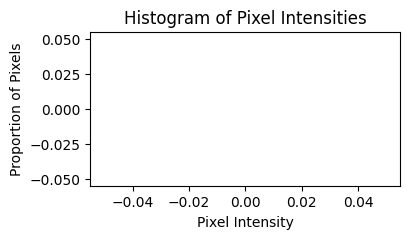

In [96]:
# Example usage
cell_image = cv2.imread("../data/cells/0/image_0a0bd90e12154009bfaa0f67ad88af08.png", cv2.IMREAD_GRAYSCALE)
visualize_histogram(cell_image)

C:\Users\barto\AppData\Local\Temp\ipykernel_4576\3928081196.py:15: RuntimeWarning: invalid value encountered in divide
  hist = hist / hist.sum()  # Normalize to [0, 1]


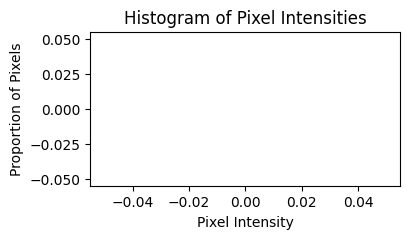

In [97]:
# Example usage
cell_image = cv2.imread("../data/cells/1/image_0a2f8fa73d3a4639826d28aae8acba47.png.png", cv2.IMREAD_GRAYSCALE)
visualize_histogram(cell_image)

### D) Classification Models based on Computed Image Features

Feature Extraction

In [99]:
import cv2
import numpy as np
from typing import List

def extract_features(cell_image: np.ndarray) -> List[float]:
    """
    Extract features from a cell image.

    Args:
        cell_image (np.ndarray): Grayscale image of the cell.

    Returns:
        List[float]: A list of extracted features.
    """
    features = []

    # 1. Mean Intensity
    mean_intensity = np.mean(cell_image)
    features.append(mean_intensity)

    # 2. Non-Zero Pixel Count
    _, binary_image = cv2.threshold(cell_image, 128, 255, cv2.THRESH_BINARY)
    non_zero_pixel_count = cv2.countNonZero(binary_image)
    features.append(non_zero_pixel_count)

    # 3. Edge Pixel Count
    edges = cv2.Canny(cell_image, 50, 150)
    edge_pixel_count = np.sum(edges > 0)
    features.append(edge_pixel_count)

    # 4. Contour Area
    _, binary_inv = cv2.threshold(cell_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary_inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour_area = max(cv2.contourArea(cnt) for cnt in contours)
    else:
        largest_contour_area = 0
    features.append(largest_contour_area)

    return features


In [100]:
from pathlib import Path

def prepare_dataset(data_dir: str):
    """
    Prepare the dataset by extracting features and labels.

    Args:
        data_dir (str): Path to the data/cells directory.

    Returns:
        tuple: (X, y), where X is the feature matrix and y is the label vector.
    """
    X = []
    y = []

    for label_dir in Path(data_dir).iterdir():
        if label_dir.is_dir():
            # label is 0 for blank cells, 1 for non-blank cells
            label = int(label_dir.name != "0")

            # iterate over cell images in the subdirectory
            for image_path in label_dir.glob("*.png"):
                cell_image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
                features = extract_features(cell_image)
                X.append(features)
                y.append(label)
    
    return np.array(X), np.array(y)

Logistic Regression

In [101]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# prepare the dataset
data_dir = "../data/cells"
X, y = prepare_dataset(data_dir)
print("Dataset ready. Training model...", end="")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train the logistic regression classifier
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)
print("Finished")

# make predictions
y_pred = clf.predict(X_test)

# evaluate the classifier
print("Classification Report:")
print(classification_report(y_test, y_pred))

Dataset ready. Training model...Finished
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.53      0.58      3721
           1       0.71      0.80      0.75      5351

    accuracy                           0.69      9072
   macro avg       0.68      0.66      0.67      9072
weighted avg       0.68      0.69      0.68      9072



Support Vector Classifier

In [102]:
from sklearn.svm import SVC

# train the SVM classifier
svm_clf = SVC(kernel="rbf", C=1.0, gamma="scale", random_state=42)  # RBF kernel is good for non-linear problems
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred))

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.79      0.75      3721
           1       0.84      0.77      0.81      5351

    accuracy                           0.78      9072
   macro avg       0.78      0.78      0.78      9072
weighted avg       0.79      0.78      0.78      9072



Random Forest Classifier

In [103]:
from sklearn.ensemble import RandomForestClassifier


# train the logistic regression classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      3721
           1       0.93      0.86      0.89      5351

    accuracy                           0.88      9072
   macro avg       0.87      0.88      0.88      9072
weighted avg       0.88      0.88      0.88      9072



Neural Network

In [104]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# prepare the dataset for PyTorch
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

train_size = int(0.8 * len(X_tensor))
test_size = len(X_tensor) - train_size
X_train, X_test = torch.utils.data.random_split(
    TensorDataset(X_tensor, y_tensor), [train_size, test_size]
)

train_loader = DataLoader(X_train, batch_size=256, shuffle=True)
test_loader = DataLoader(X_test, batch_size=256)

# define the neural network
class BlankClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BlankClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),  # Input to hidden layer
            nn.ReLU(),
            nn.Linear(64, 32),        # Hidden to hidden
            nn.ReLU(),
            nn.Linear(32, 1),          # Output layer
            nn.Sigmoid()               # Binary classification
        )
    
    def forward(self, x):
        return self.model(x)

# initialize the model
input_dim = X.shape[1]  # Number of features
model = BlankClassifier(input_dim)

# loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.1)

# train the model
epochs = 50
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Evaluate the model
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        predictions = model(X_batch).squeeze()
        y_true.extend(y_batch.numpy())
        y_pred.extend((predictions > 0.5).numpy())

from sklearn.metrics import classification_report
print("Neural Network Classification Report:")
print(classification_report(y_true, y_pred))


Epoch 1/50, Loss: 58.2535
Epoch 2/50, Loss: 58.1487
Epoch 3/50, Loss: 57.1779
Epoch 4/50, Loss: 61.3957
Epoch 5/50, Loss: 60.8513
Epoch 6/50, Loss: 58.8542
Epoch 7/50, Loss: 58.8542
Epoch 8/50, Loss: 55.5816
Epoch 9/50, Loss: 58.1914
Epoch 10/50, Loss: 56.5767
Epoch 11/50, Loss: 54.5015
Epoch 12/50, Loss: 59.8958
Epoch 13/50, Loss: 62.8247
Epoch 14/50, Loss: 58.3333
Epoch 15/50, Loss: 64.4566
Epoch 16/50, Loss: 57.2303
Epoch 17/50, Loss: 60.3542
Epoch 18/50, Loss: 53.5499
Epoch 19/50, Loss: 58.2525
Epoch 20/50, Loss: 53.5630
Epoch 21/50, Loss: 58.7766
Epoch 22/50, Loss: 56.2500
Epoch 23/50, Loss: 64.0625
Epoch 24/50, Loss: 61.3599
Epoch 25/50, Loss: 61.7939
Epoch 26/50, Loss: 56.9525
Epoch 27/50, Loss: 57.2044
Epoch 28/50, Loss: 63.9817
Epoch 29/50, Loss: 65.4729
Epoch 30/50, Loss: 55.6601
Epoch 31/50, Loss: 56.1409
Epoch 32/50, Loss: 61.3639
Epoch 33/50, Loss: 67.1224
Epoch 34/50, Loss: 66.6667
Epoch 35/50, Loss: 54.9667
Epoch 36/50, Loss: 58.8542
Epoch 37/50, Loss: 61.3801
Epoch 38/5

c:\Users\barto\Documents\DS2024Z\ISR\ISR-2024W-SudokuSolver\isrenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\barto\Documents\DS2024Z\ISR\ISR-2024W-SudokuSolver\isrenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\barto\Documents\DS2024Z\ISR\ISR-2024W-SudokuSolver\isrenv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

### E) Custom CNN

In [34]:
import torch
from torch.utils.data import Dataset
import cv2
import os
from pathlib import Path

class SudokuCellDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.data = []
        self.labels = []

        # load data and labels
        for label_dir in self.data_dir.iterdir():
            if label_dir.is_dir():
                label = int(label_dir.name == "0")  # 0 for blank, 1 for non-blank
                for image_path in label_dir.glob("*.png"):
                    self.data.append(str(image_path))
                    self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # load image
        image_path = self.data[idx]
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (28, 28))
        image = image / 255.0

        # apply transforms, if any
        if self.transform:
            image = self.transform(image)

        # convert to tensor
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label


In [35]:
import torch.nn as nn

class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # convolutional Layer
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # downsampling

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),  # FC Layer
            nn.ReLU(),
            nn.Linear(128, 2)  # Output Layer (2 classes: blank or non-blank)
        )

    def forward(self, x):
        return self.model(x)


In [36]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim

# load dataset
data_dir = "../data/cells"
dataset = SudokuCellDataset(data_dir)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# initialize model, loss, and optimizer
model = CNNClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")


Epoch 1/20, Loss: 330.2279
Epoch 2/20, Loss: 269.3371
Epoch 3/20, Loss: 248.9331
Epoch 4/20, Loss: 237.8925
Epoch 5/20, Loss: 224.6183
Epoch 6/20, Loss: 212.8314
Epoch 7/20, Loss: 200.3093
Epoch 8/20, Loss: 186.5698
Epoch 9/20, Loss: 175.5726
Epoch 10/20, Loss: 166.5482
Epoch 11/20, Loss: 155.9694
Epoch 12/20, Loss: 148.6769
Epoch 13/20, Loss: 143.3112
Epoch 14/20, Loss: 136.7876
Epoch 15/20, Loss: 133.2443
Epoch 16/20, Loss: 127.1187
Epoch 17/20, Loss: 124.1999
Epoch 18/20, Loss: 119.8782
Epoch 19/20, Loss: 119.5383
Epoch 20/20, Loss: 115.2368


In [37]:
from sklearn.metrics import classification_report

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

print("Classification Report:")
print(classification_report(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      5327
           1       0.87      0.96      0.91      3745

    accuracy                           0.92      9072
   macro avg       0.92      0.93      0.92      9072
weighted avg       0.93      0.92      0.92      9072



In [38]:
torch.save(model, "blank_cell_classifier.pth")

In [39]:
torch.save(model.state_dict(), "blank_cell_classifier_1.pth")